# Subclustering of Midline cells in integration data

In [1]:
#loading packages
library(Seurat)
library(ggplot2)
library(magrittr)
library(data.table)
library(Matrix)
library(dplyr)
library(tibble)
library(harmony)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] harmony_0.1.0     Rcpp_1.0.7        tibble_3.0.5      dplyr_1.0.3      
[5] Matrix_1.3-2      data.table_1.13.6 magrittr_2.0.1    ggplot2_3.3.3    
[9] Seurat_3.2.3     

loaded via a namespace (and not attached):
 [1] nlme_3.1-151          matrixStats_0.57.0    RcppAnnoy_0.0.18     
 [4] RColorBrewer_1.1-2    httr_1.4.2            repr_1.1.0           
 [7] sctransform_0.3.2     tools_4.0.3           R6_2.5.1             
[10] irlba_2.3.3           rpart_4.1-15          KernSmooth_2.23-18

In [3]:
func.centering <- function(seu){
    DefaultAssay(seu) <- 'SCT'
    scale.data <- GetAssayData(seu, assay = 'SCT', slot = 'scale.data') #Get scale.data
    new.data <- ScaleData(object = scale.data, do.scale = F, do.center = T) #centering scale.data
    
    seu <- SetAssayData(object = seu, assay = 'SCT',
                        slot = 'scale.data', new.data = new.data) #insert centering data into scale.data slot
    return(seu)
    
}

func.normalize <- function(seu){
    
    if(dim(seu)[2]>=500){
        #Re-Normalize data only when the number of cell in the target clusters > 500.
        DefaultAssay(seu) <- 'RNA'
        if(seu$set[1]=='Set 1'){
            vars.to.regress <- c("percent.mt", "percent.rRNA","percent.ERCC")
        }else{
            vars.to.regress <- c("percent.mt", "percent.rRNA")
        }
        seu <- suppressWarnings(SCTransform(seu, vars.to.regress = vars.to.regress))
    }else{
        #If The number of cells < 500, re-normalization is skipped and only centering is performed.
        seu <- func.centering(seu)
    }
    return(seu)
}

func.subclustering.prep <- function(seu){
    obj.list <- SplitObject(seu, split.by = 'set')
    
    print(obj.list)
    
    obj.list <- lapply(X = obj.list, FUN = func.normalize)
    print(obj.list)
    integration.features <- SelectIntegrationFeatures(object.list = obj.list, nfeatures = 3000)
    seu <- merge(x = obj.list[['Set 3']], y = c(obj.list[['Set 2']],obj.list[['Set 1']],obj.list[['NK-data']]))
    VariableFeatures(seu) <- integration.features
    seu <- RunPCA(seu)
    seu <- RunHarmony(object = seu, group.by.vars = 'set', assay.use="SCT")
    seu <- RunUMAP(seu, dims = 1:30, n.neighbors = 20L, reduction = 'harmony')
    seu <- RunUMAP(seu, dims = 1:30, n.neighbors = 20L, reduction = 'pca', reduction.name = 'umapwoharmony')

    options(repr.plot.width=16, repr.plot.height=8)
    p <- DimPlot(seu, reduction = 'umapwoharmony', group.by = 'set') + DimPlot(seu, reduction = 'umap', group.by = 'set')
    plot(p)
    
    print(seu)
    return(seu)
}

func.subclustering <- function(seu, resolution=0.8){
    seu <- FindNeighbors(seu, dims = 1:30, reduction = 'harmony')
    seu <- FindClusters(seu, resolution = resolution)
    options(repr.plot.width=16, repr.plot.height=8)
    p <- DimPlot(seu, reduction = 'umap', label = T) + NoLegend() + DimPlot(seu, reduction = 'umap', group.by = 'set')
    plot(p)
    return(seu)
}

In [4]:
#loading data
seu_HQC <- readRDS(file = '../../data/seurat_object/all_integration/seu_Harmony_integrated.obj')
seu_HQC

An object of class Seurat 
25136 features across 13467 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


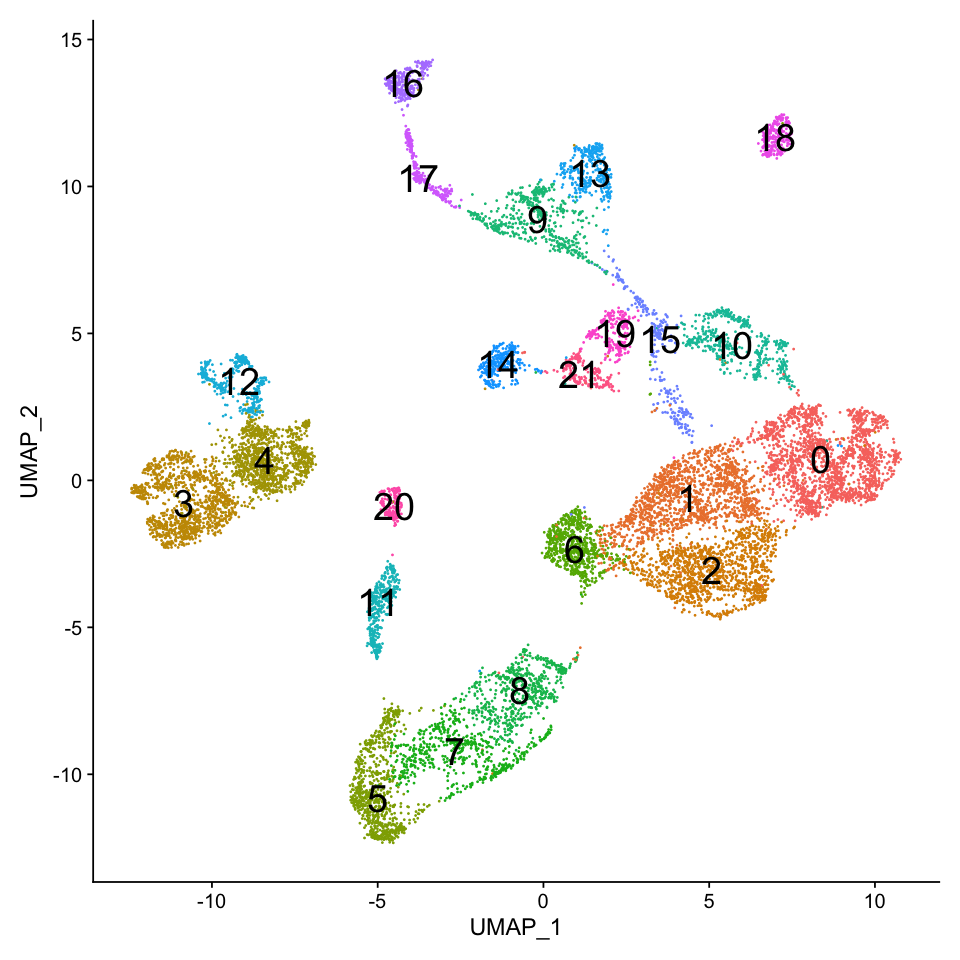

In [5]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu_HQC, reduction = 'umap', label = TRUE, label.size = 8) + NoLegend()

## Picking up target clusters

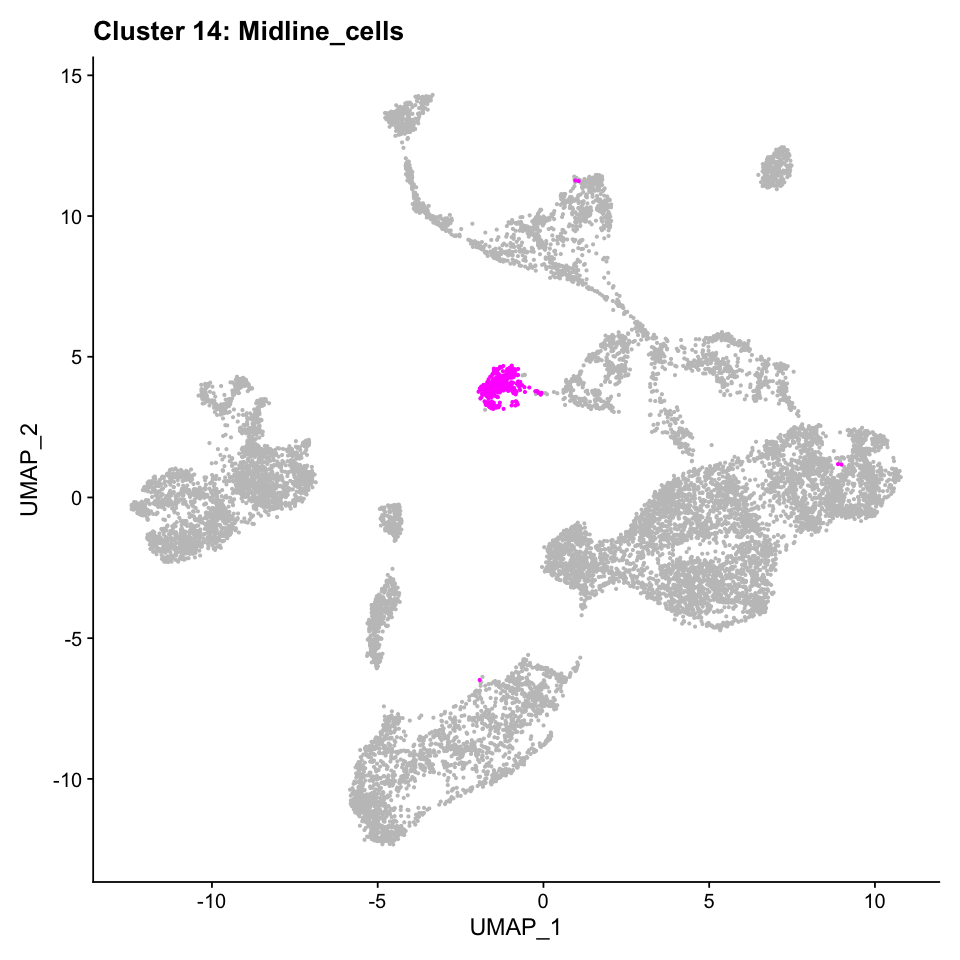

In [6]:
options(repr.plot.width=8, repr.plot.height=8)
highlight.cells <- WhichCells(seu_HQC,idents = c(14))
DimPlot(seu_HQC, reduction =  "umap", cells.highlight = highlight.cells, pt.size = 0.5, sizes.highlight = 0.5,
        cols.highlight = 'magenta', label = FALSE) + NoLegend() + ggtitle('Cluster 14: Midline_cells')

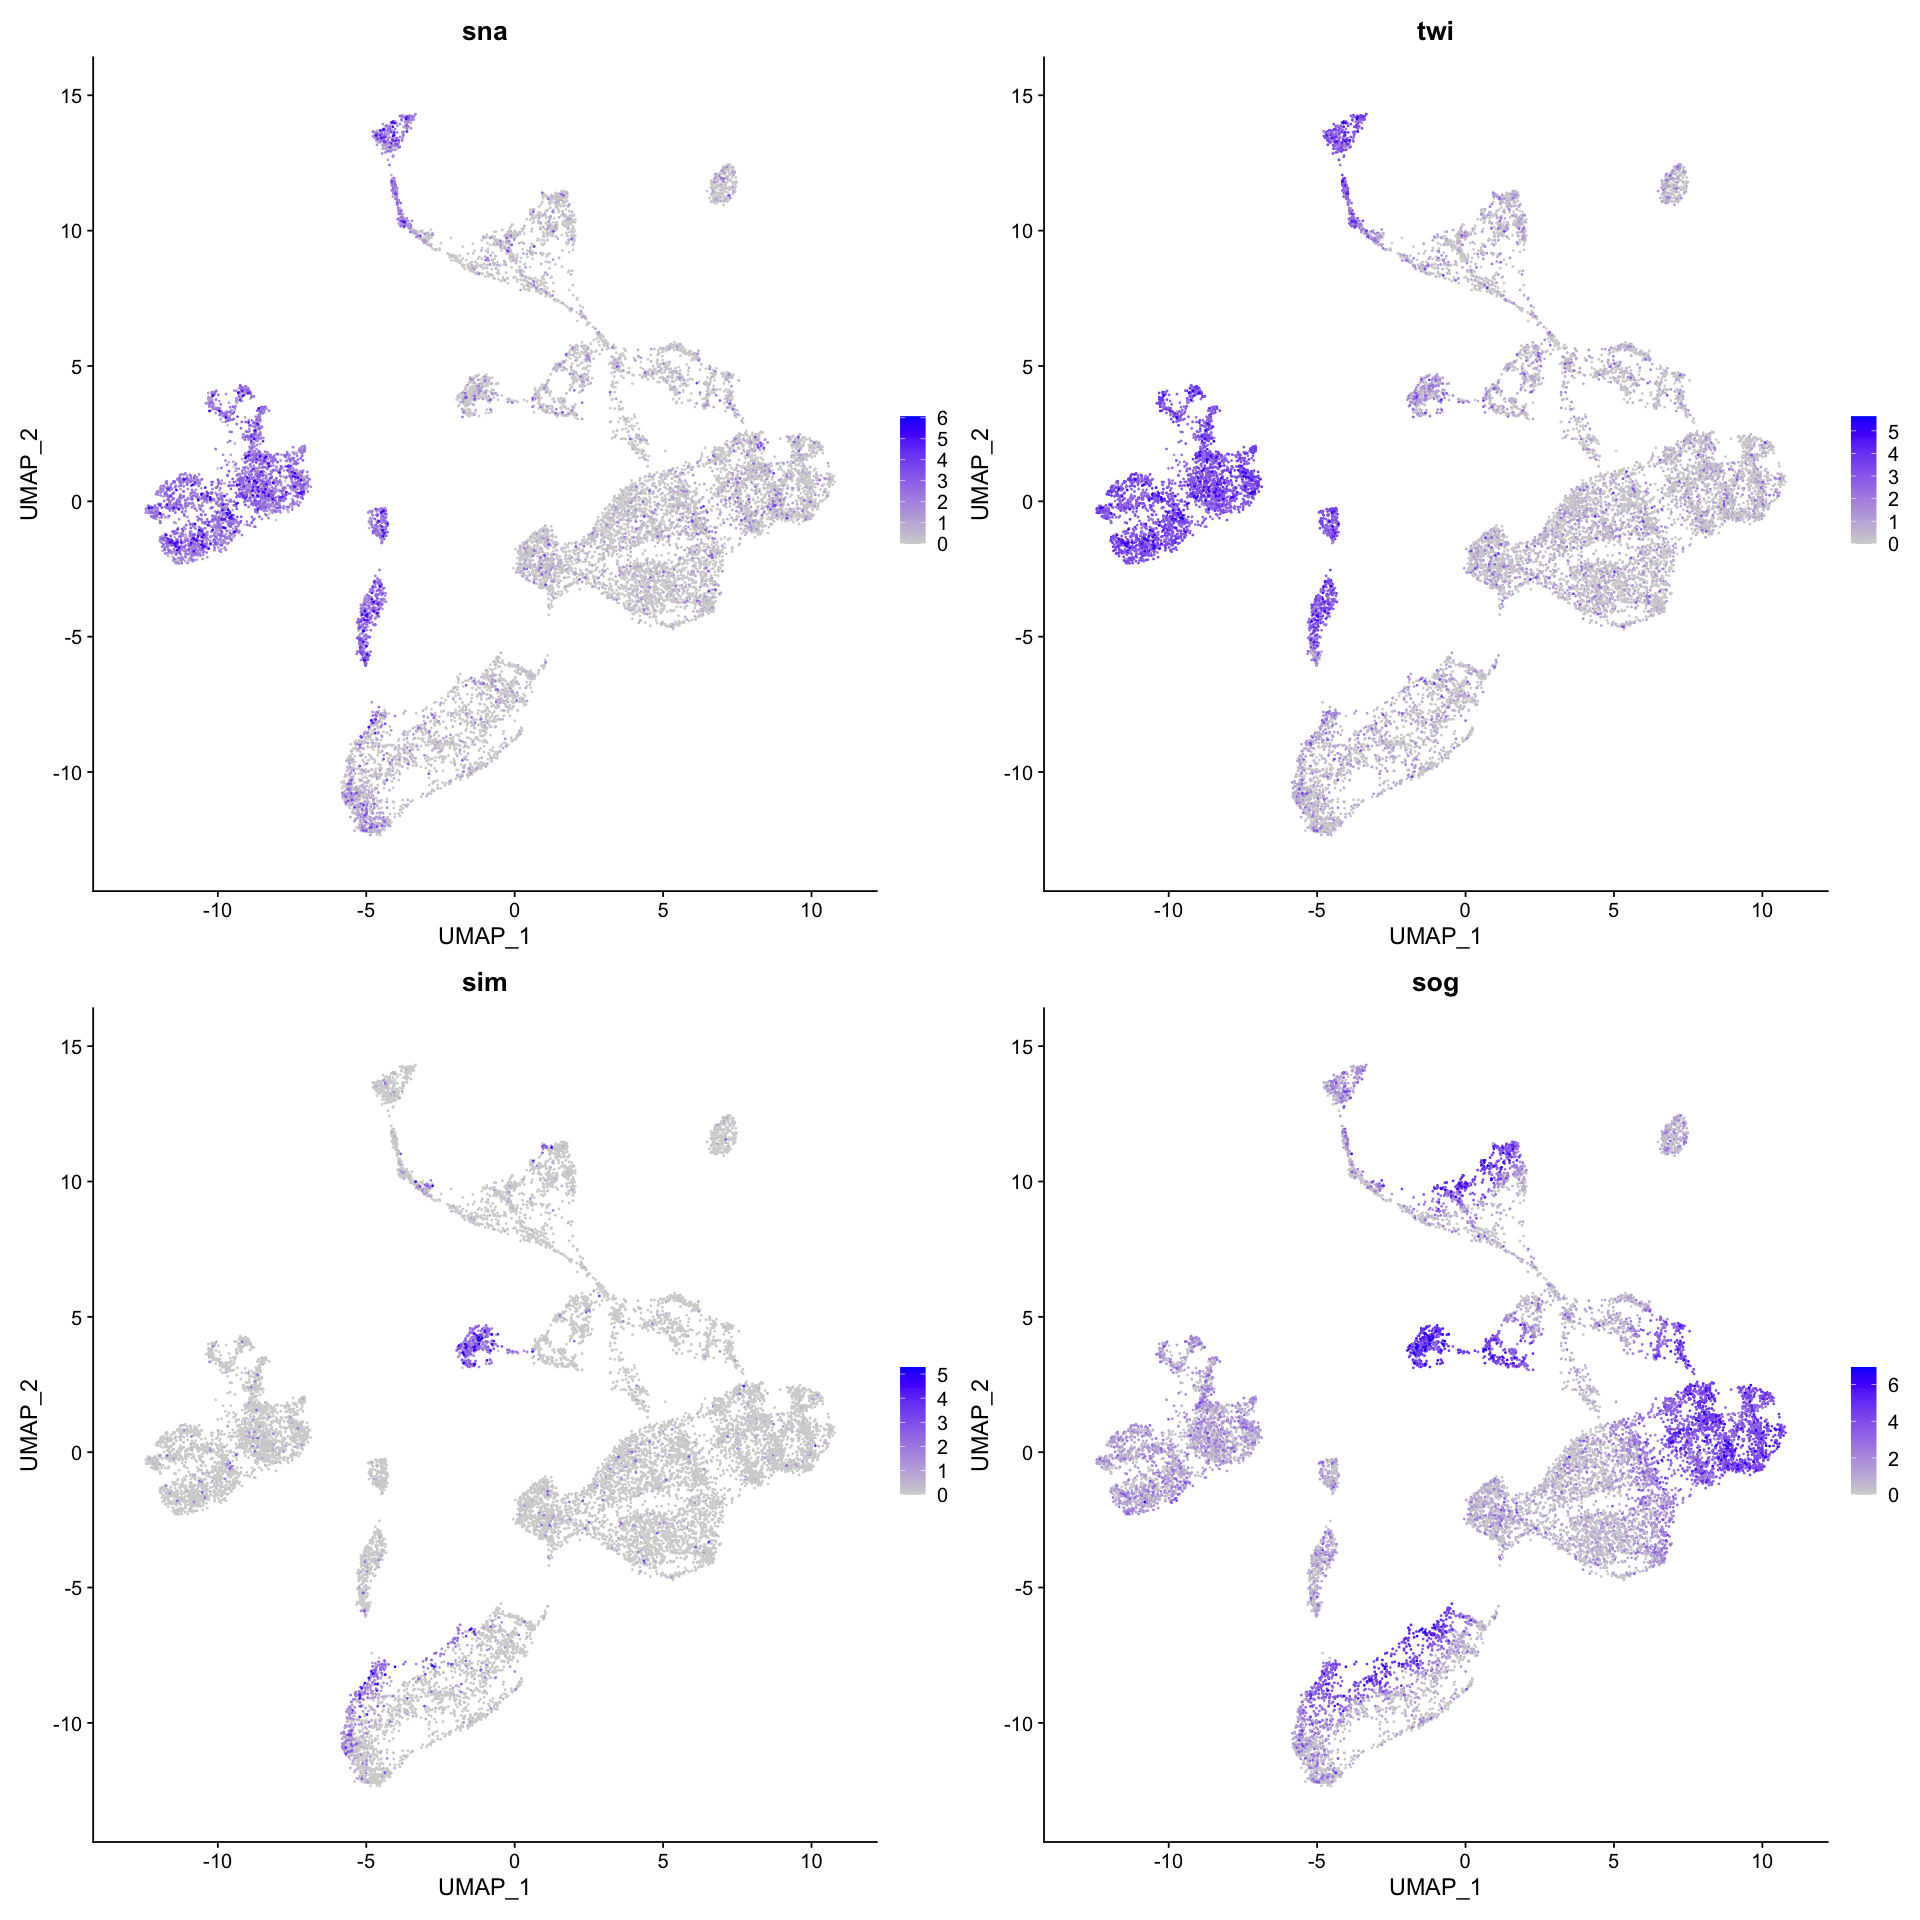

In [7]:
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu_HQC, features = c('sna','twi','sim','sog'))

In [8]:
seu.midline <- subset(seu_HQC, idents = c(14))
seu.midline

An object of class Seurat 
25136 features across 301 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

## Clustering

$`Set 3`
An object of class Seurat 
25136 features across 138 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 2`
An object of class Seurat 
25136 features across 95 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`NK-data`
An object of class Seurat 
25136 features across 39 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 1`
An object of class Seurat 
25136 features across 29 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony



Centering data matrix

Centering data matrix

Centering data matrix

Centering data matrix



$`Set 3`
An object of class Seurat 
25136 features across 138 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 2`
An object of class Seurat 
25136 features across 95 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`NK-data`
An object of class Seurat 
25136 features across 39 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 1`
An object of class Seurat 
25136 features across 29 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony



PC_ 1 
Positive:  trn, lncRNA:bxd, Ubx, toc, ftz, hth, nub, Dl, blot, S 
	   abd-A, Nrt, lncRNA:iab4, crb, Pka-C3, Ppa, Glut4EF, robo2, odd, CG10035 
	   lncRNA:roX1, Dscam1, ptc, wech, lncRNA:noe, Ama, SNCF, NimC4, Alh, lncRNA:CR43887 
Negative:  ImpL2, ich, CG43355-sala, salm, edl, D, eve, E(spl)m2-BFM, Abd-B, Cys 
	   CG43394, lncRNA:CR44931, jeb, gsb, stg, CG13427, Ect3, lncRNA:CR45559, E(spl)mbeta-HLH, Ilp4 
	   Obp99a, CG12986, CG42762, E(spl)mgamma-HLH, wg, mfas, path, CG42808, Blimp-1, CG17716 
PC_ 2 
Positive:  slp1, trn, pxb, Ubx, slp2, wg, RpS15, RpS11, RpL27A, lok 
	   gsb, CG10035, CG13427, RpL41, RpS20, Lac, pri, RpL10, RpL38, lncRNA:CR34335 
	   Ilp4, RpLP2, CG4440, RpLP1, RpL21, RpL37a, RpS18, prd, crb, RpS16 
Negative:  edl, ImpL2, ich, stg, brk, E(spl)m2-BFM, E(spl)m6-BFM, S, Sema1b, bbg 
	   vnd, tkv, vn, jeb, scyl, sim, rho, Abd-B, Dl, SoxN 
	   Zasp52, mid, be, Obp99a, side-V, CG43394, toc, lncRNA:CR43432, Tet, Cys 
PC_ 3 
Positive:  eve, ich, Abd-B, mid, hh, CG177

An object of class Seurat 
25136 features across 301 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 4 dimensional reductions calculated: pca, harmony, umap, umapwoharmony


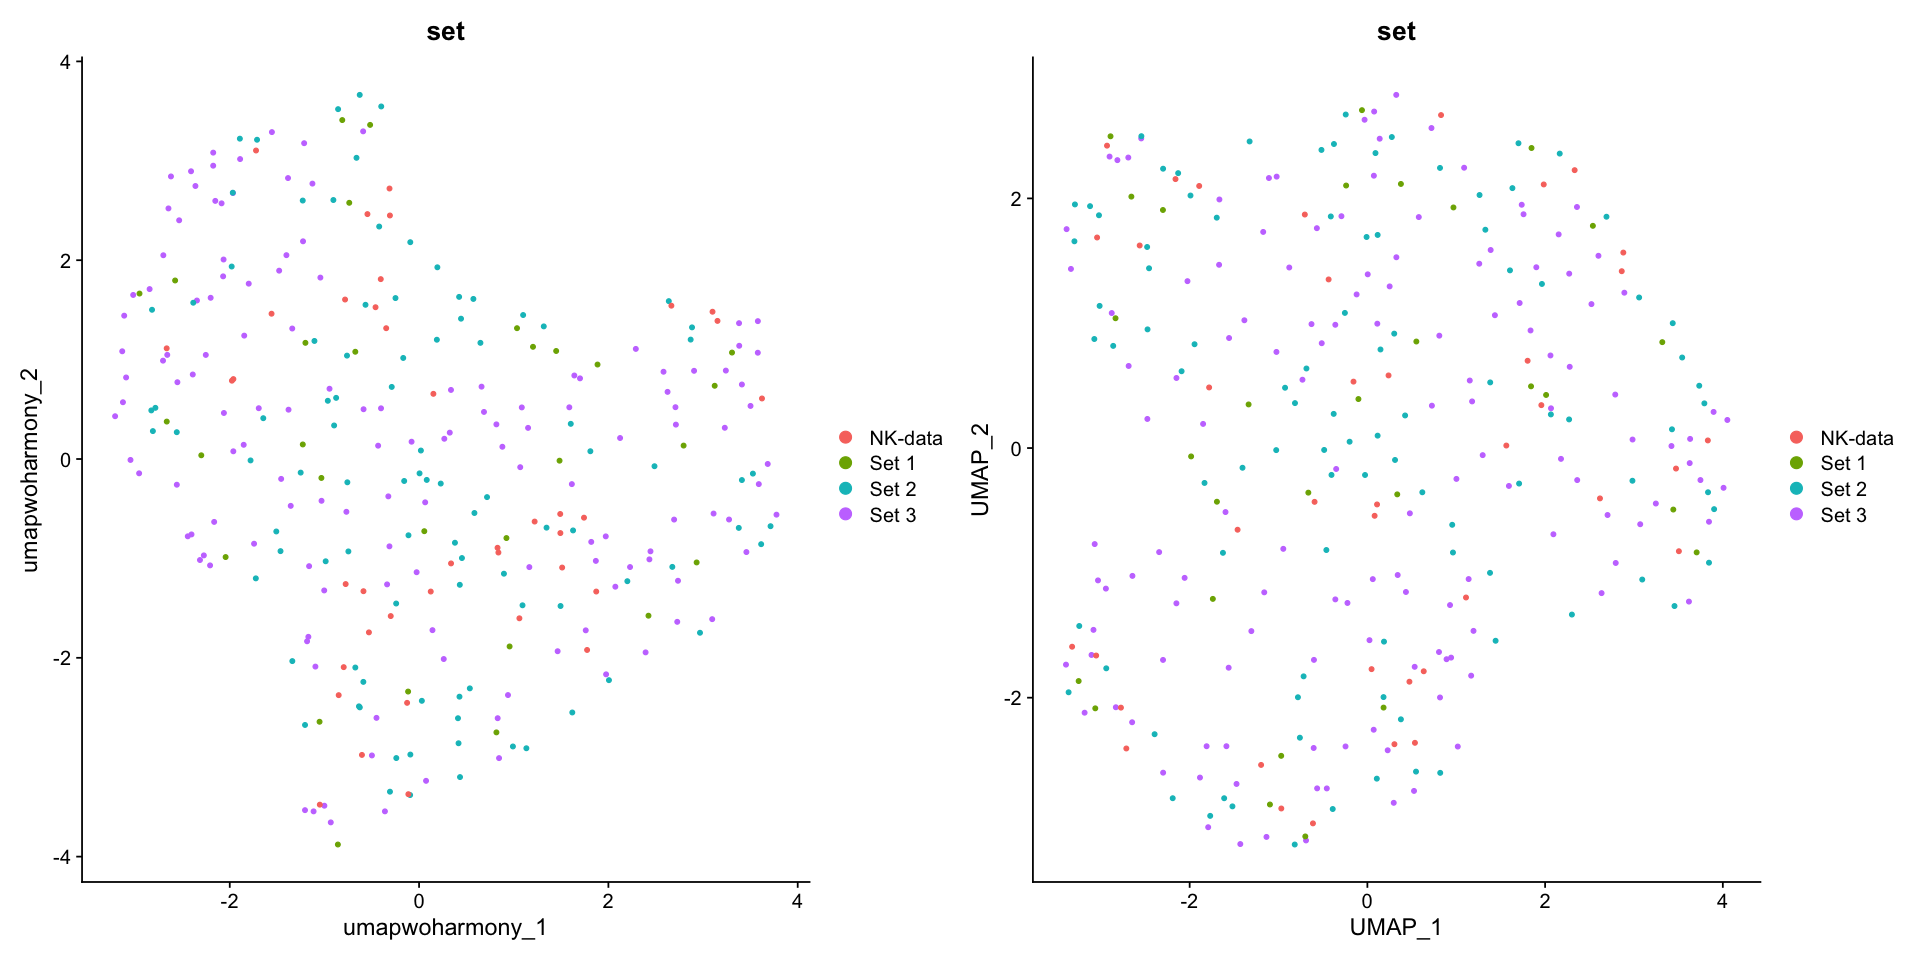

In [9]:
seu.midline <- func.subclustering.prep(seu.midline)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 301
Number of edges: 23124

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3140
Number of communities: 3
Elapsed time: 0 seconds


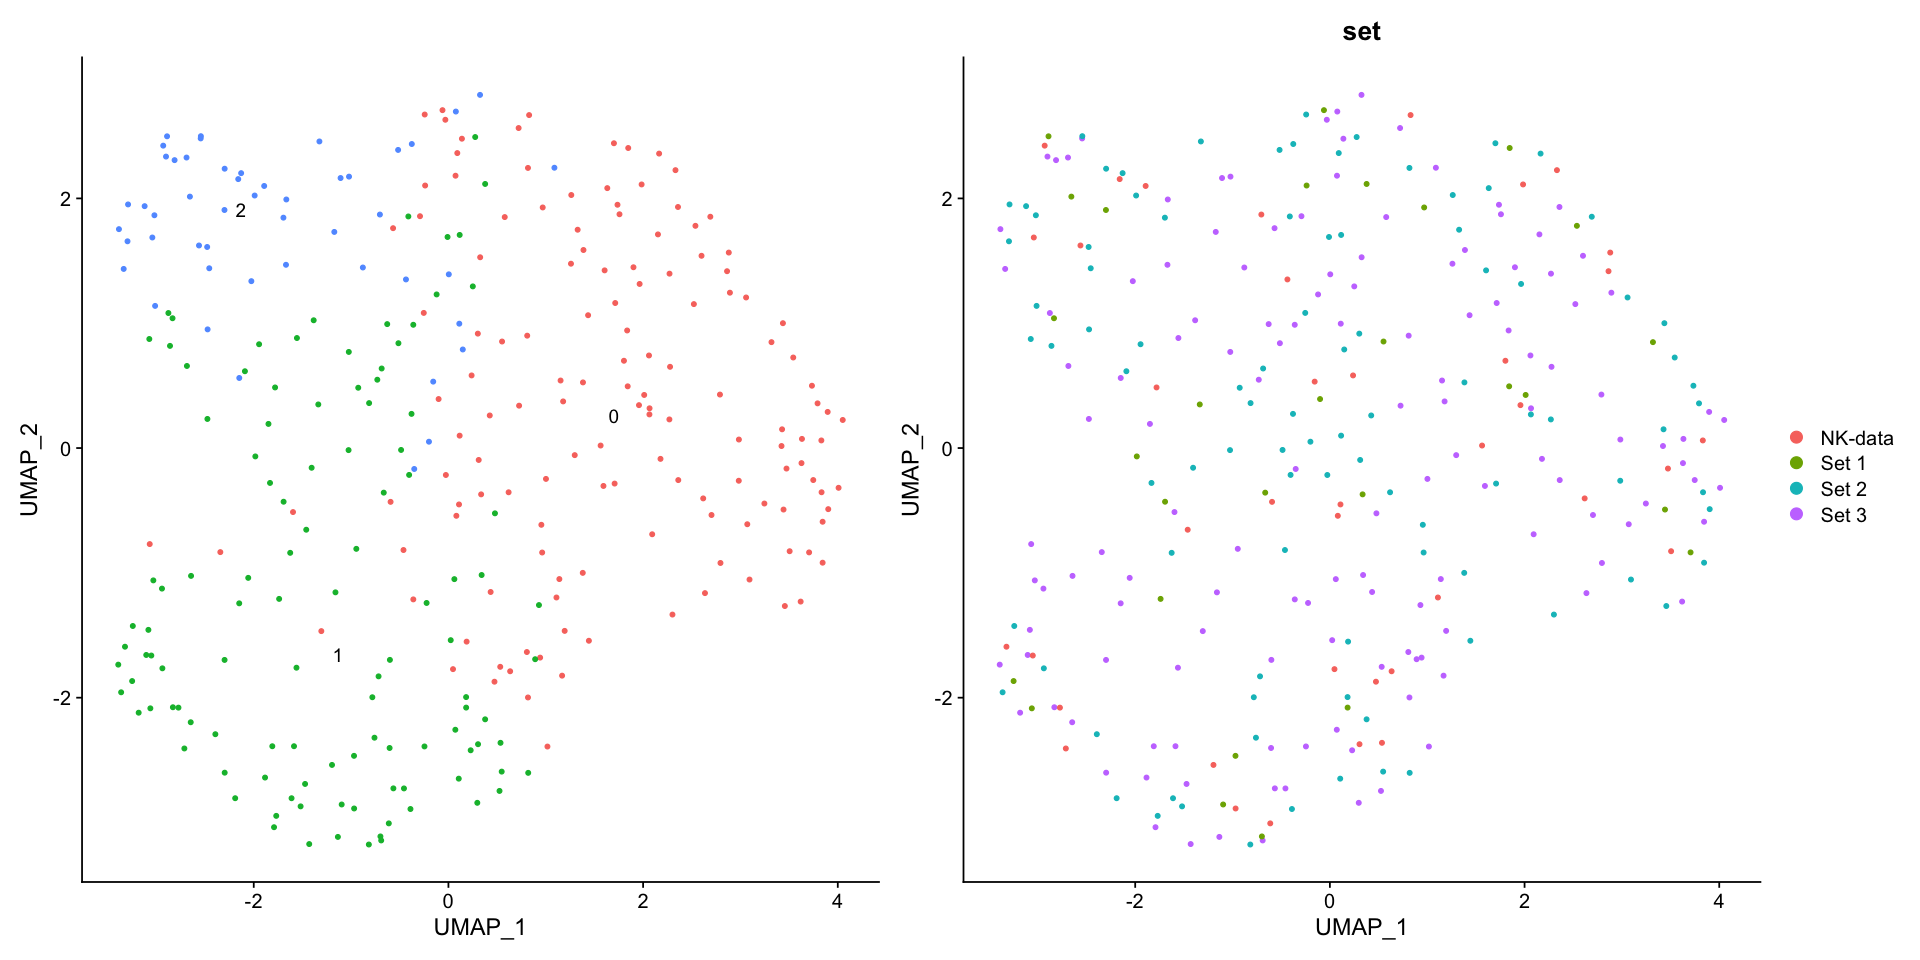

In [10]:
seu.midline <-func.subclustering(seu.midline)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 301
Number of edges: 23124

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2393
Number of communities: 4
Elapsed time: 0 seconds


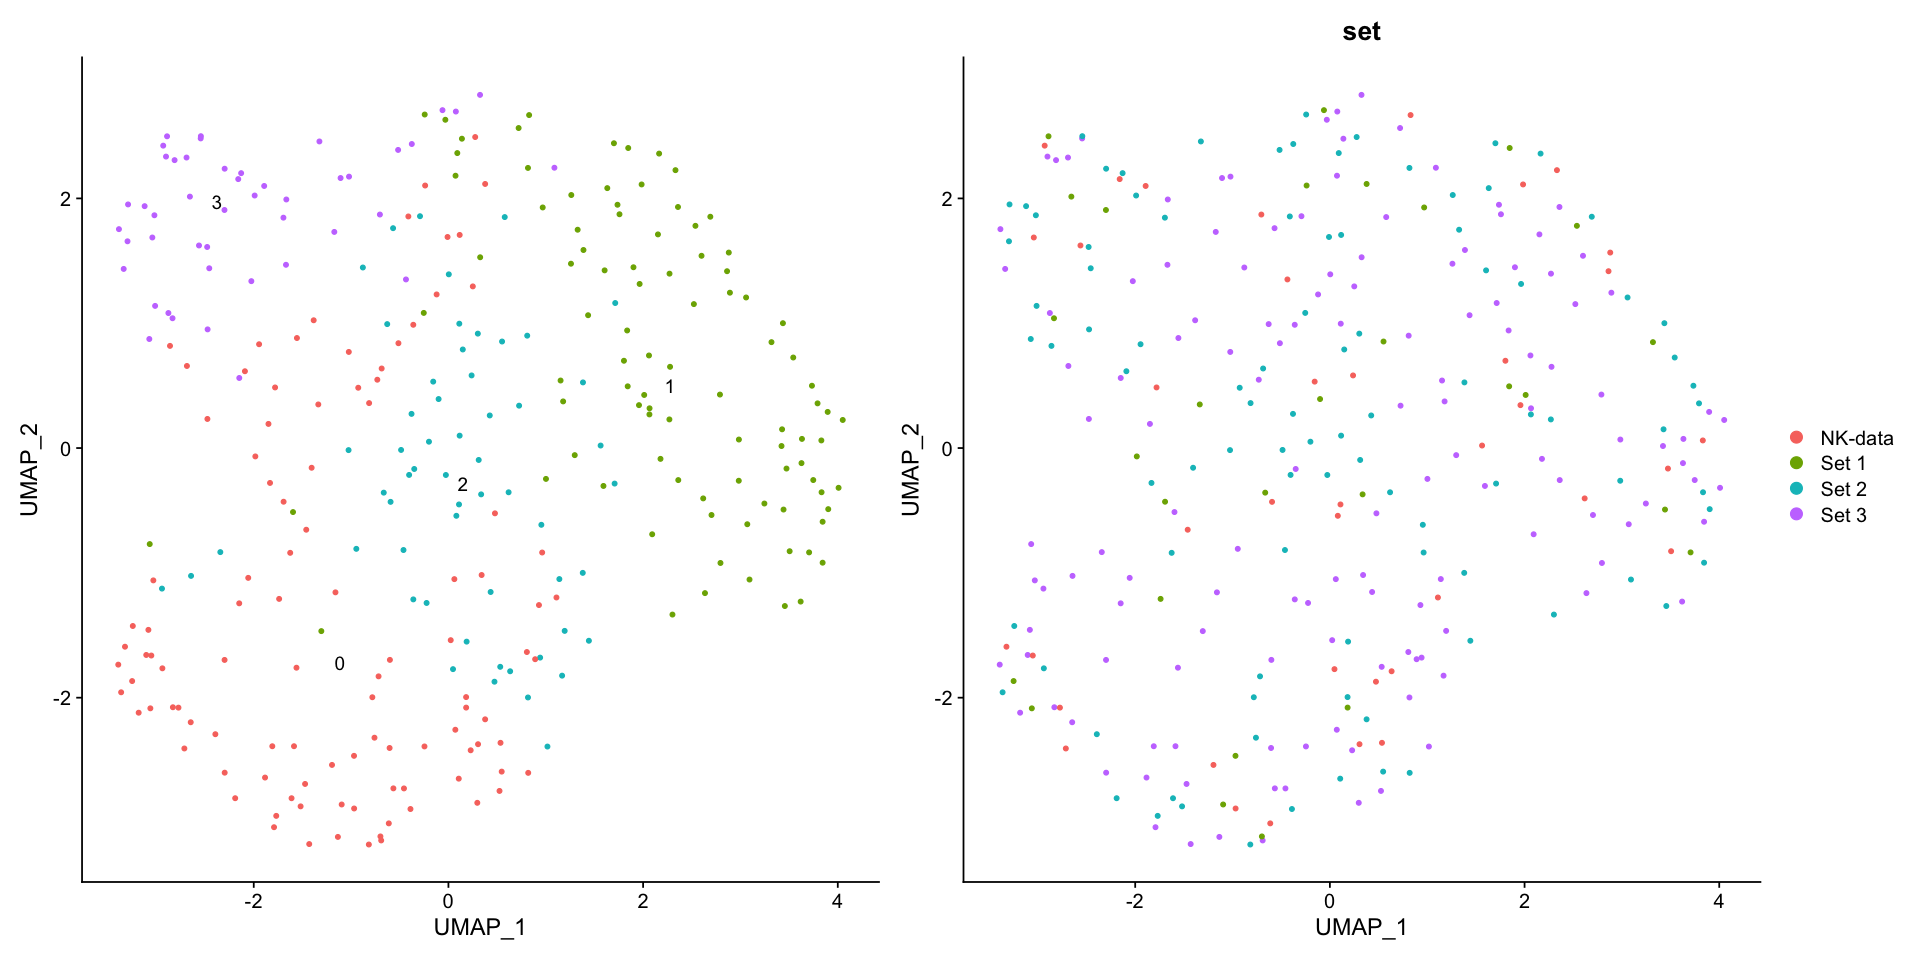

In [11]:
seu.midline <-func.subclustering(seu.midline, resolution = 1.0)

In [12]:
all.markers <- FindAllMarkers(object = seu.midline, only.pos = TRUE)
nrow(all.markers)
all.markers.top10 <- all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
nrow(all.markers.top10)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



[1] 197

[1] 32

Warning message in DoHeatmap(seu.midline, features = c(all.markers.top10$gene)):
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: mus205”


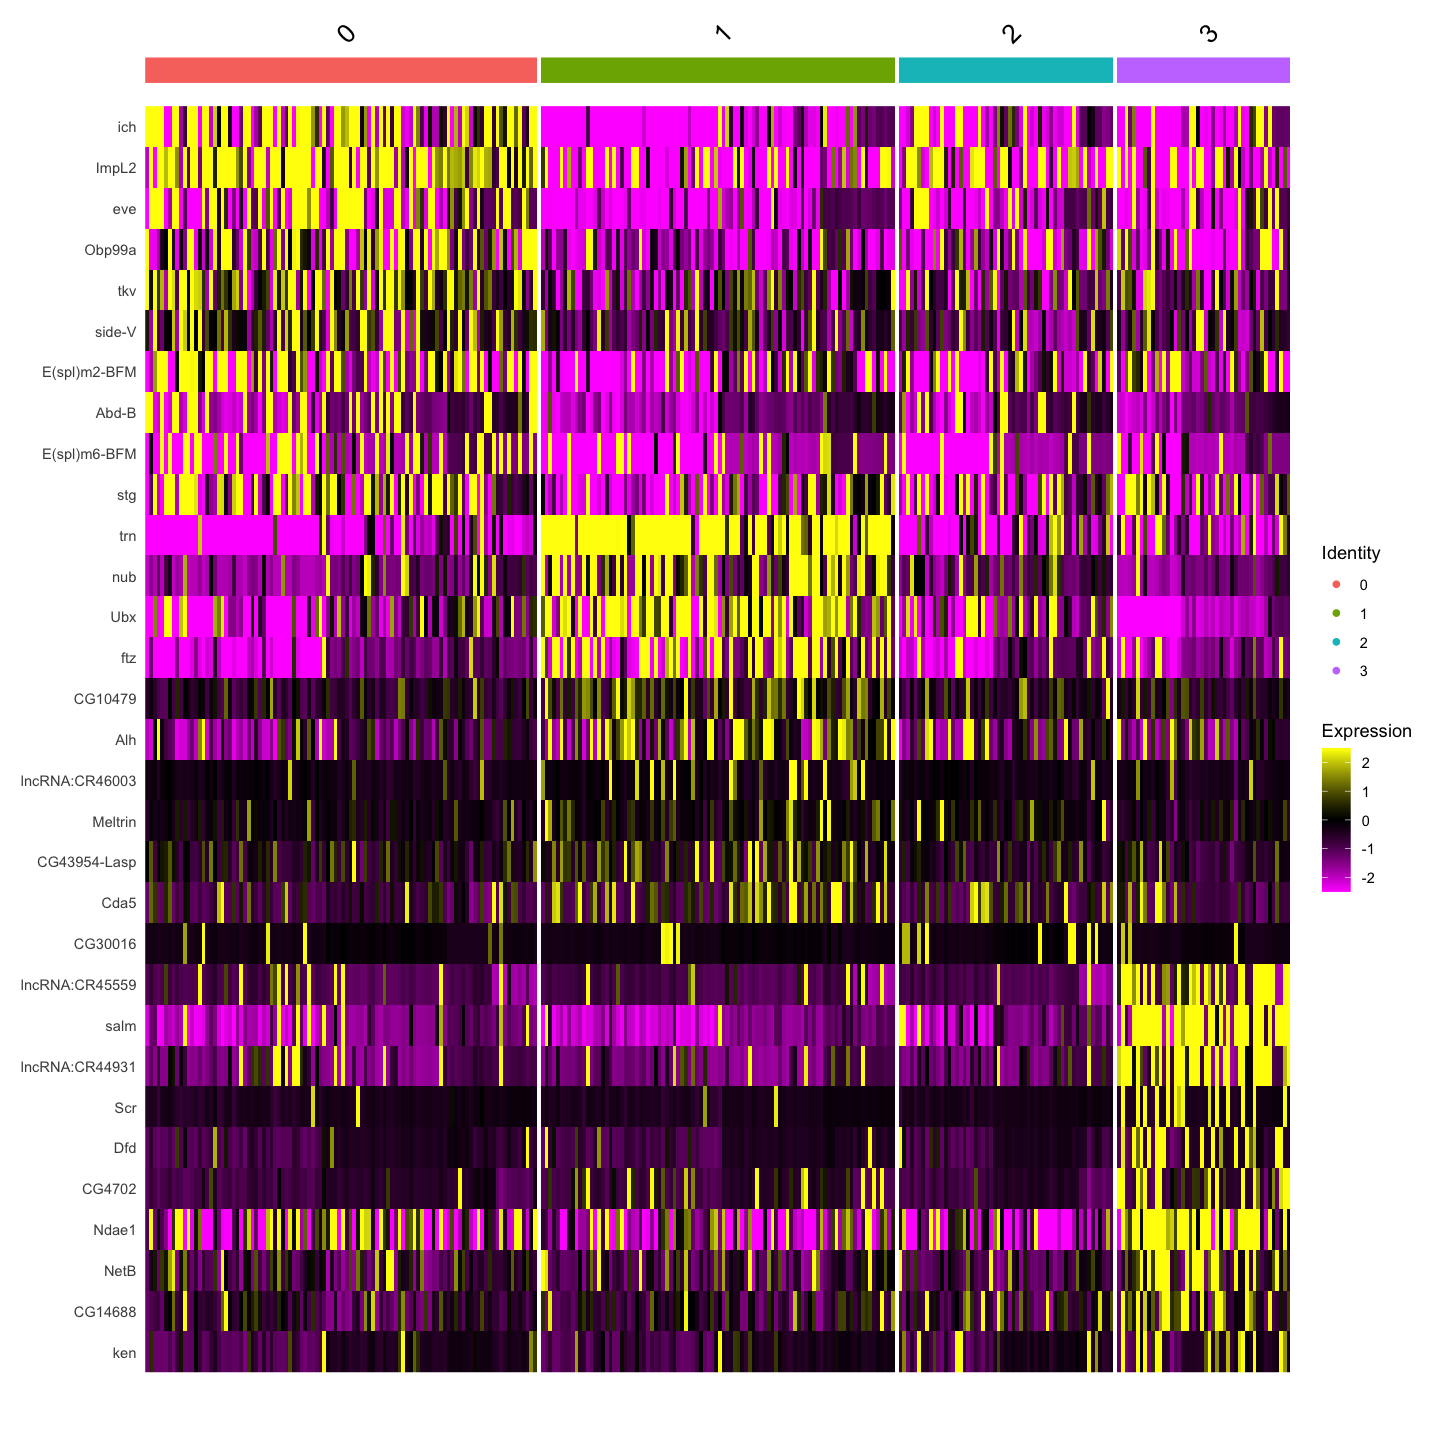

In [13]:
options(repr.plot.width=12, repr.plot.height=12)
DoHeatmap(seu.midline, features = c(all.markers.top10$gene))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 301
Number of edges: 23124

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2728
Number of communities: 3
Elapsed time: 0 seconds


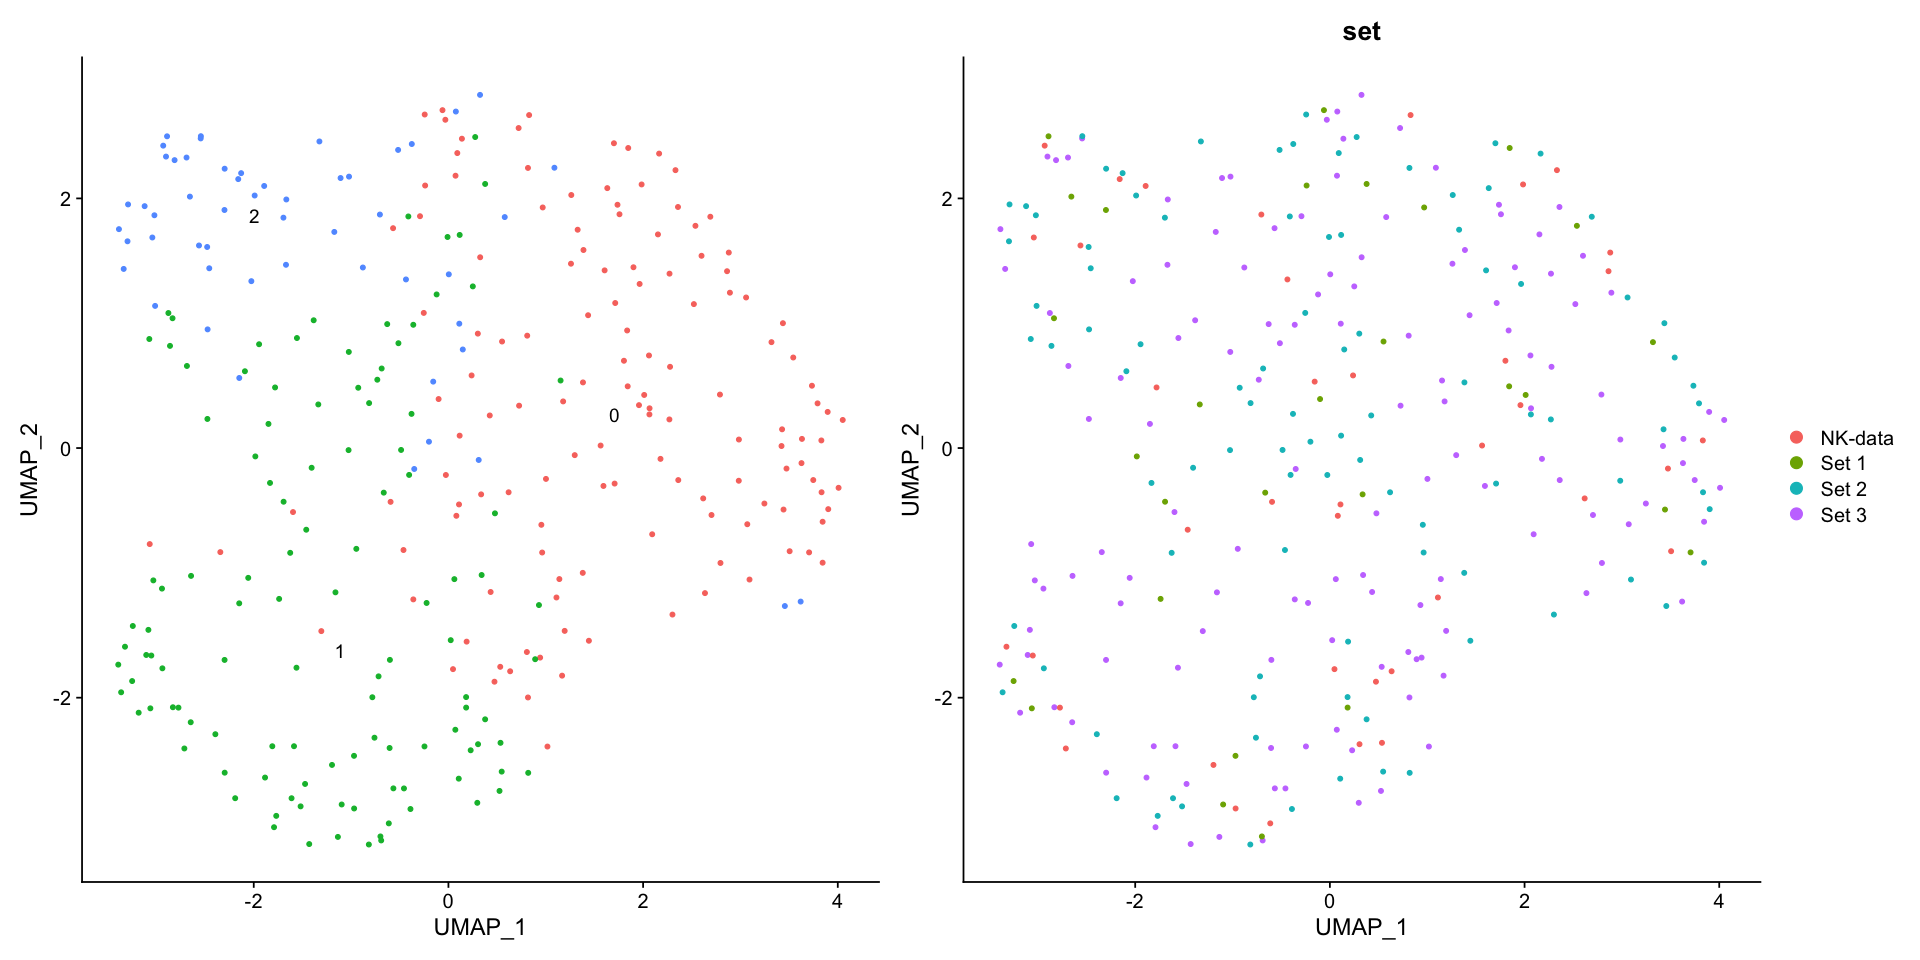

In [14]:
seu.midline <-func.subclustering(seu.midline, resolution = 0.9)

In [15]:
all.markers <- FindAllMarkers(object = seu.midline, only.pos = TRUE)
nrow(all.markers)
all.markers.top10 <- all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
nrow(all.markers.top10)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2



[1] 163

[1] 30

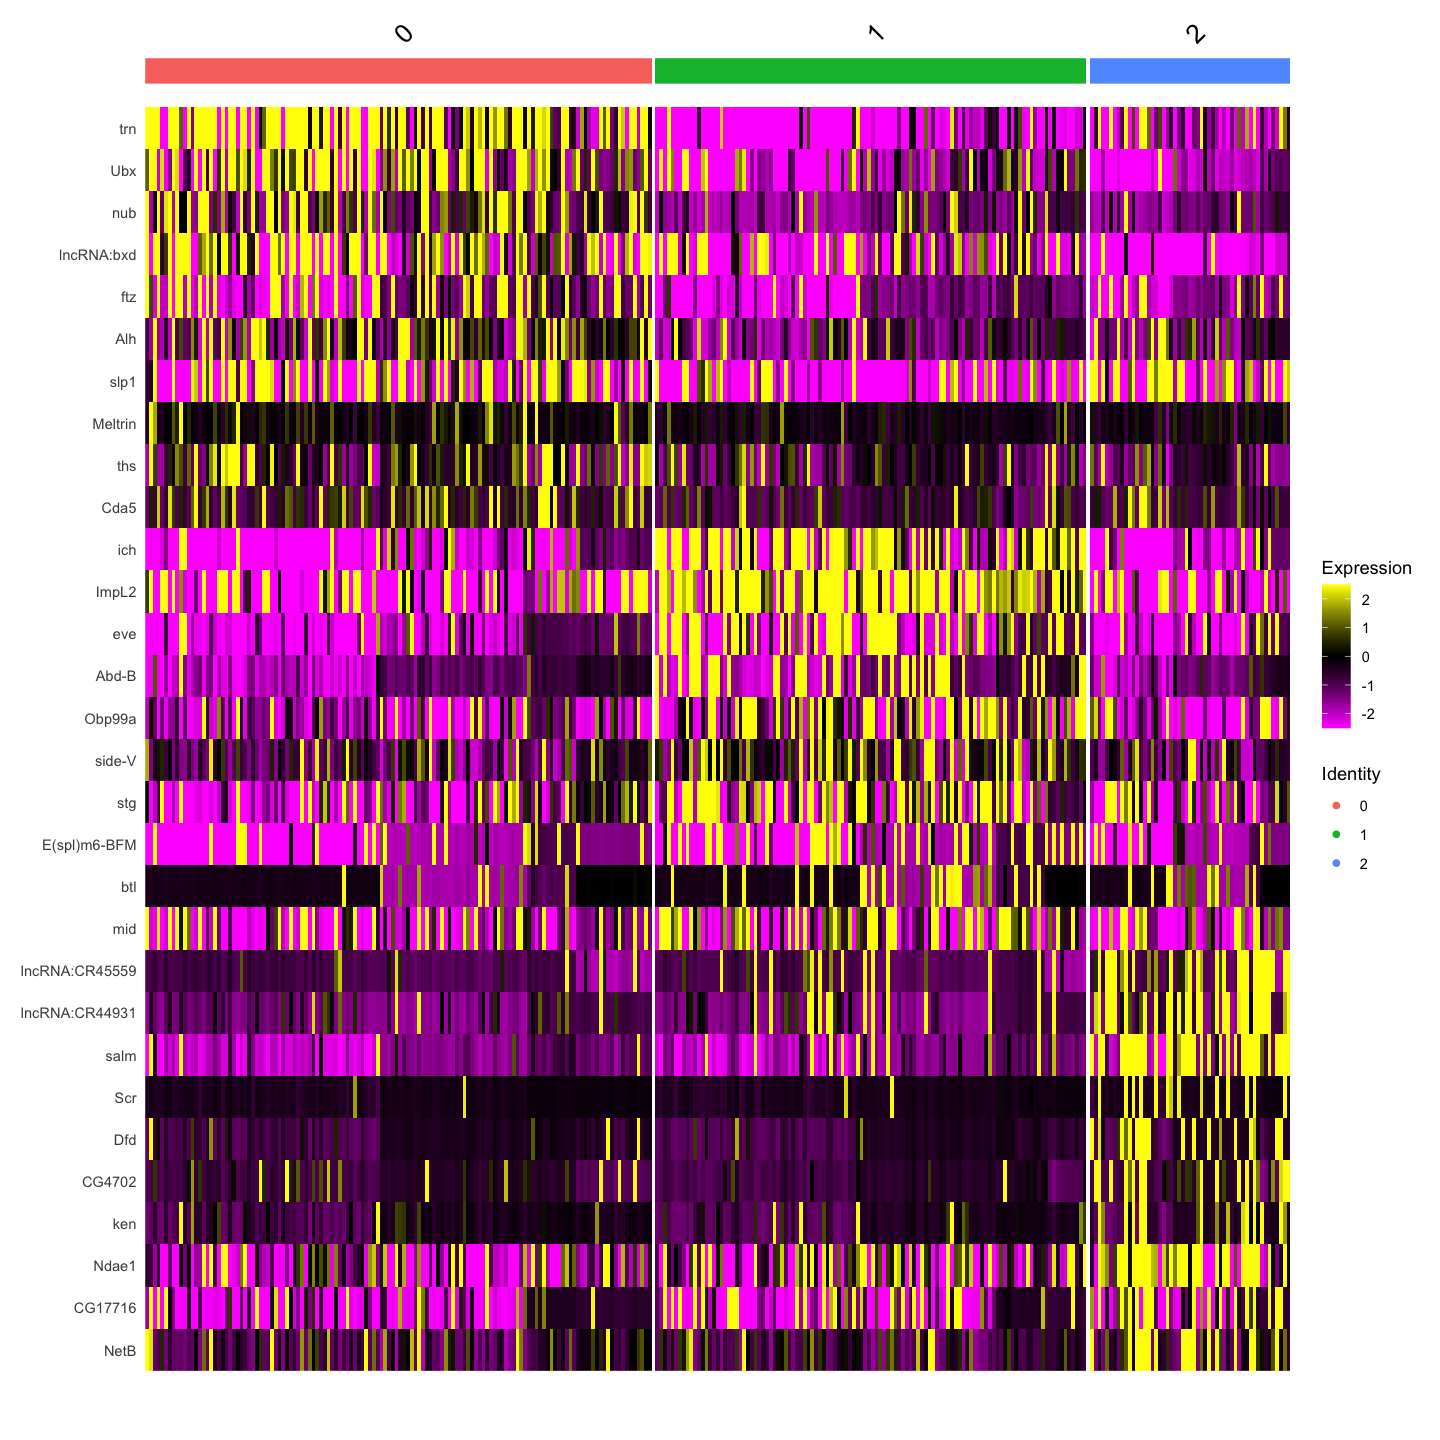

In [16]:
options(repr.plot.width=12, repr.plot.height=12)
DoHeatmap(seu.midline, features = c(all.markers.top10$gene))

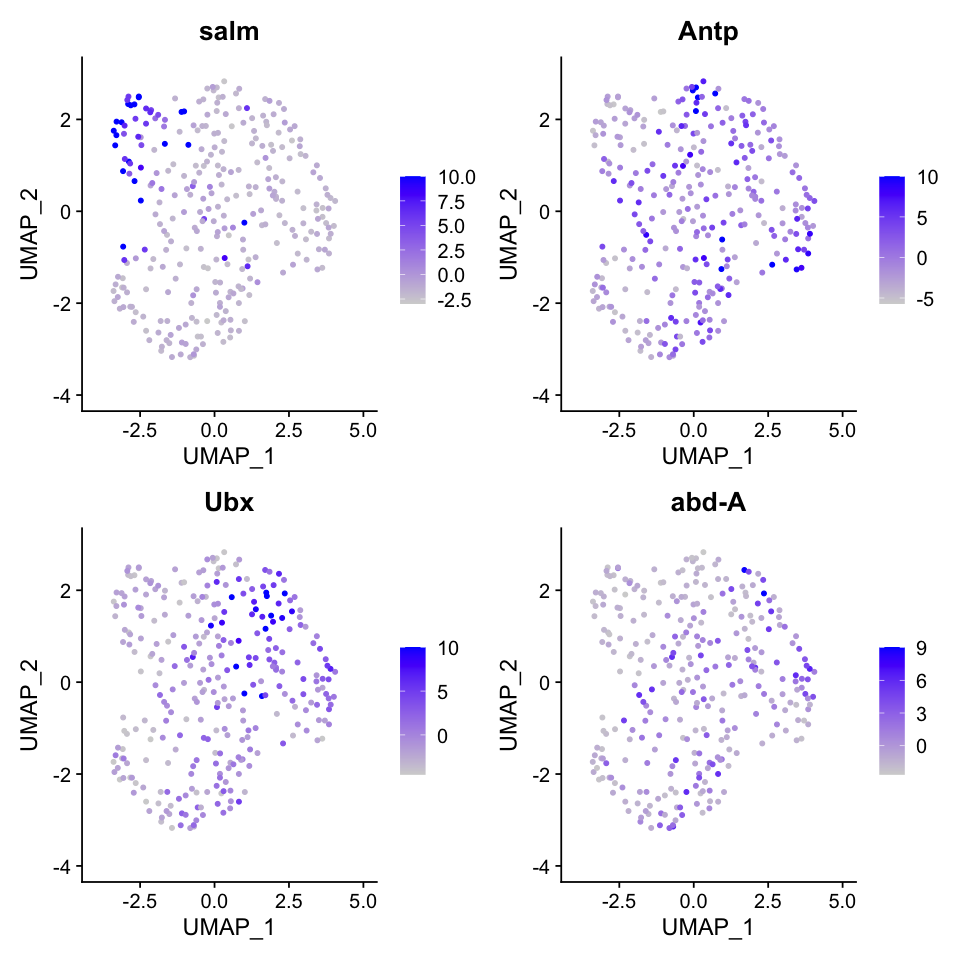

In [17]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(seu.midline, reduction = "umap", features = c("salm","Antp","Ubx","abd-A"), 
            pt.size = 1,  ncol = 2, slot = 'scale.data')

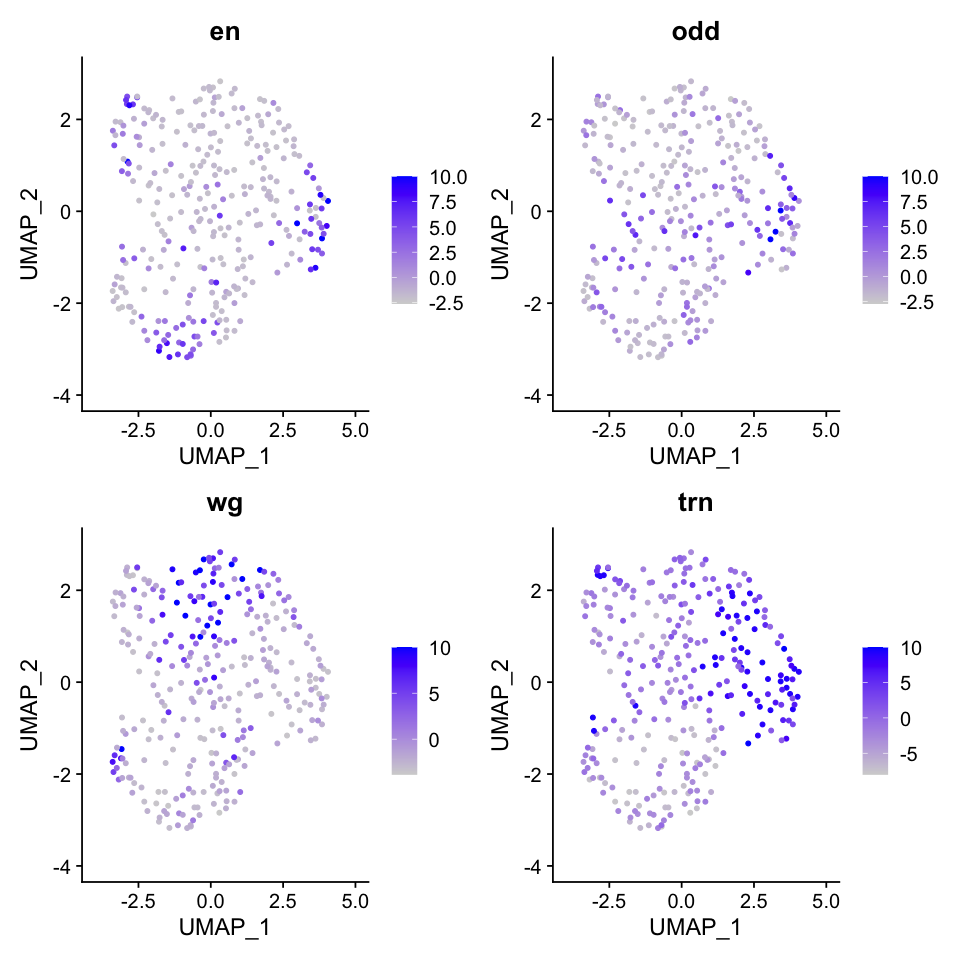

In [18]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(seu.midline, reduction = "umap", features = c("en","odd","wg","trn"), 
            pt.size = 1,  ncol = 2, slot = 'scale.data')

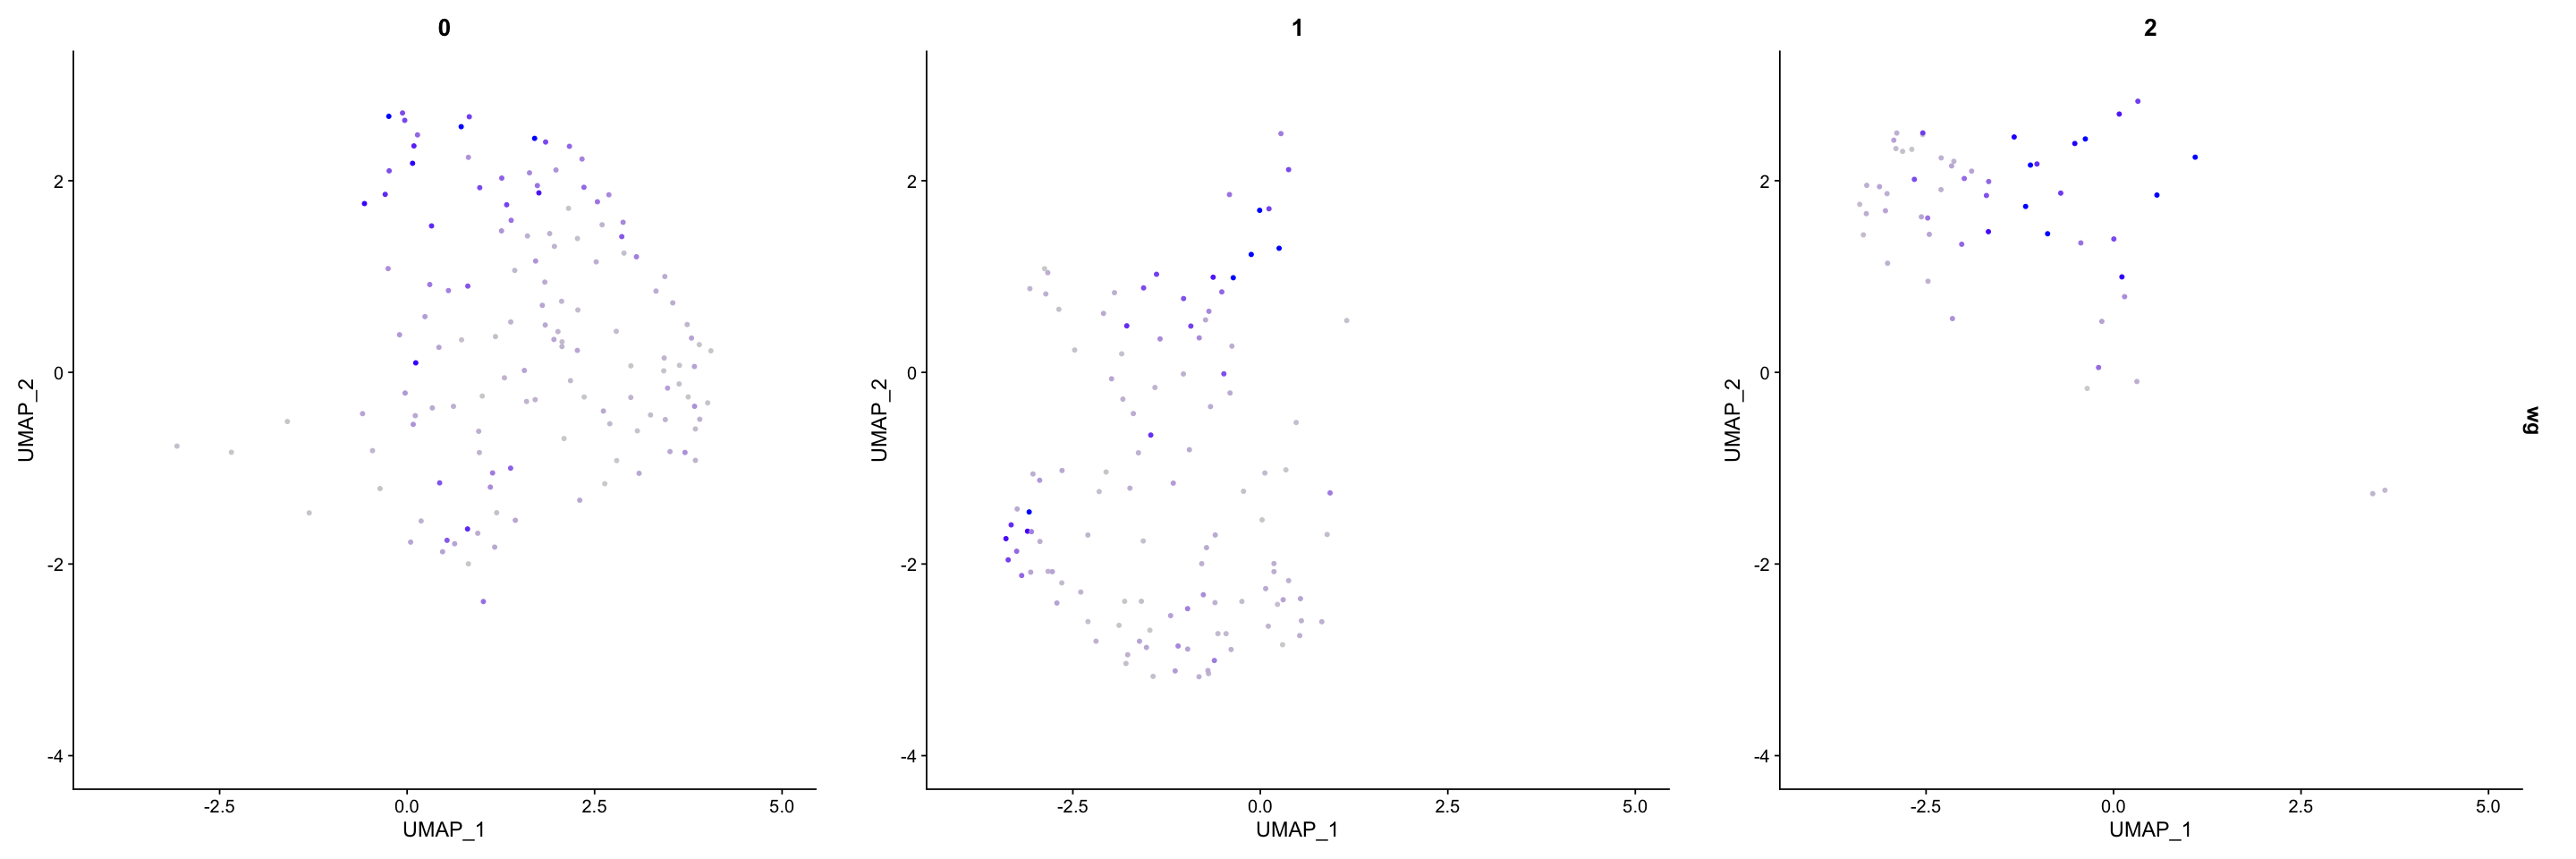

In [19]:
options(repr.plot.width=24, repr.plot.height=8)
FeaturePlot(seu.midline, reduction = "umap", features = c("wg"), split.by = 'seurat_clusters',
            pt.size = 1,  ncol = 2, slot = 'scale.data')

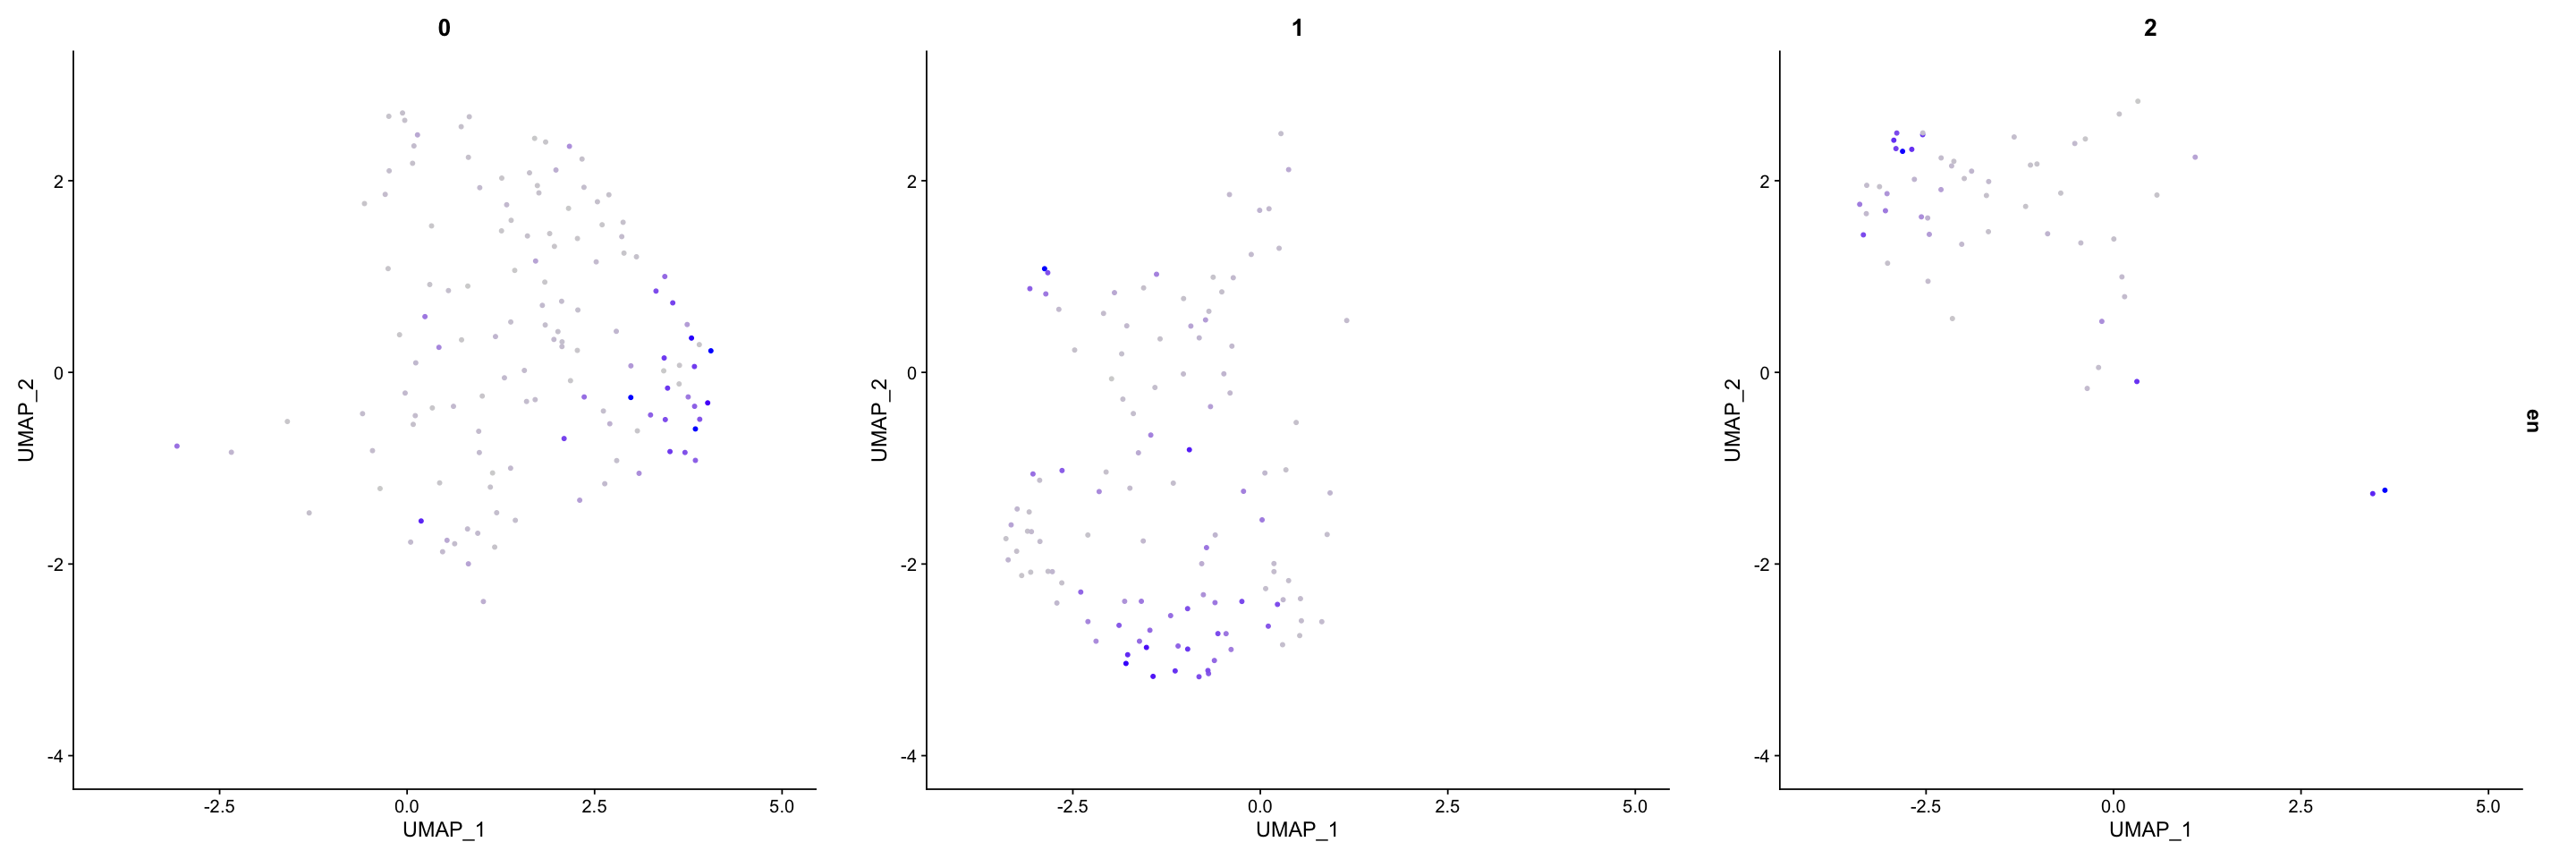

In [20]:
options(repr.plot.width=24, repr.plot.height=8)
FeaturePlot(seu.midline, reduction = "umap", features = c("en"), split.by = 'seurat_clusters',
            pt.size = 1,  ncol = 2, slot = 'scale.data')

## Add annotation

manual_ID
Set3_ATGCGATCACGTACAT 2        
Set3_AACCATGTCTTCCCGA 2        
Set3_AACGGGACACATTGTG 0        
Set3_AAGACTCAGACTTGTC 2        
Set3_AAGATAGGTACTGCGC 0        
Set3_AAGGTAACATCCCACT 0

manual_ID                   
Set3_ATGCGATCACGTACAT midline_cells_PS1-3         
Set3_AACCATGTCTTCCCGA midline_cells_PS1-3         
Set3_AACGGGACACATTGTG midline_cells_abdominal_even
Set3_AAGACTCAGACTTGTC midline_cells_PS1-3         
Set3_AAGATAGGTACTGCGC midline_cells_abdominal_even
Set3_AAGGTAACATCCCACT midline_cells_abdominal_even

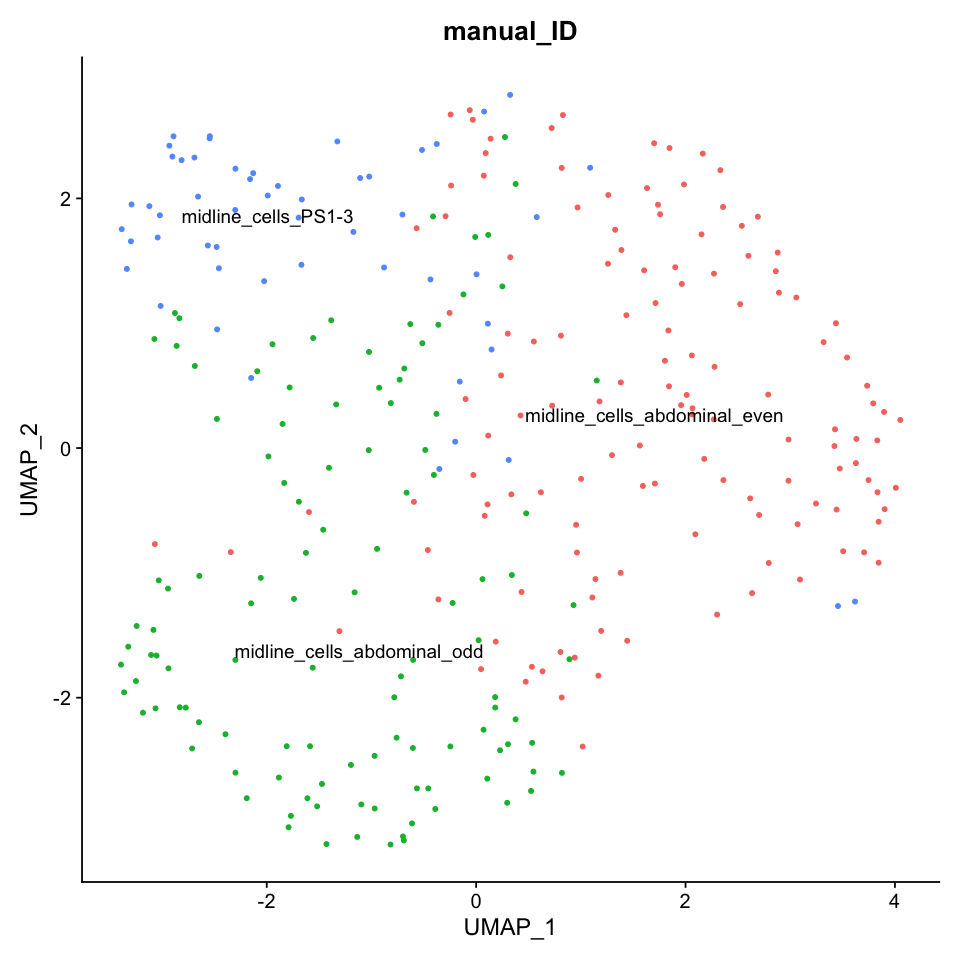

In [21]:
manual_id <- as.data.frame(seu.midline$seurat_clusters)
colnames(manual_id) <- c('manual_ID')
head(manual_id)
manual_id$manual_ID = dplyr::recode(manual_id$manual_ID, 
                                     "0"="midline_cells_abdominal_even", 
                                     "1"="midline_cells_abdominal_odd",
                                     "2"="midline_cells_PS1-3"
                                    
                                   )
                                    

head(manual_id)
seu.midline$manual_ID <- manual_id
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu.midline, reduction = 'umap', label = T, group.by = 'manual_ID') + NoLegend() 

In [22]:
Idents(seu.midline) <- 'manual_ID'
levels(seu.midline) <- c('midline_cells_PS1-3','midline_cells_abdominal_even','midline_cells_abdominal_odd')

In [23]:
all.markers <- FindAllMarkers(object = seu.midline, only.pos = TRUE)
nrow(all.markers)
all.markers.top10 <- all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
nrow(all.markers.top10)

Calculating cluster midline_cells_PS1-3

Calculating cluster midline_cells_abdominal_even

Calculating cluster midline_cells_abdominal_odd



[1] 163

[1] 30

Saving 7 x 7 in image



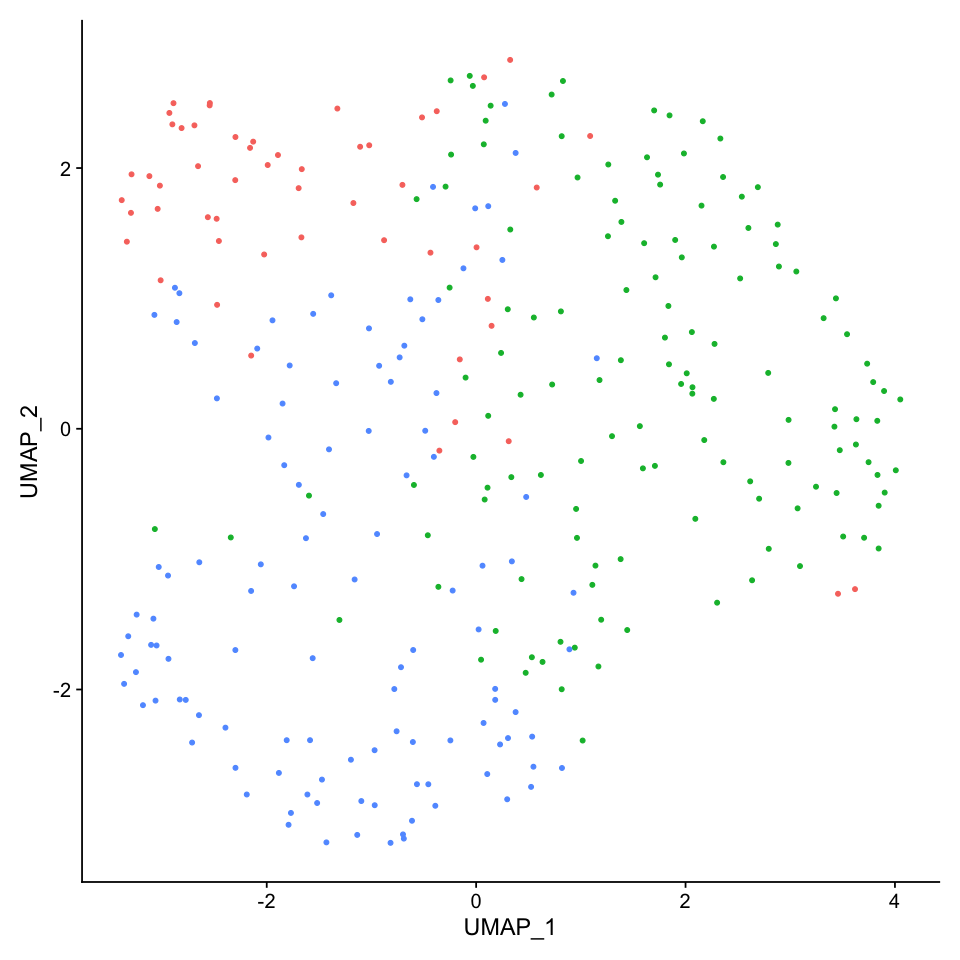

In [24]:
options(repr.plot.width=8, repr.plot.height=8)
fig <- DimPlot(seu.midline, reduction =  "umap", label = FALSE) + NoLegend() 

fig
ggsave(fig, file = "./figures/03_midline_subclustering_integrate_all/midline_umap1.eps", dpi = 300)

Saving 7 x 7 in image



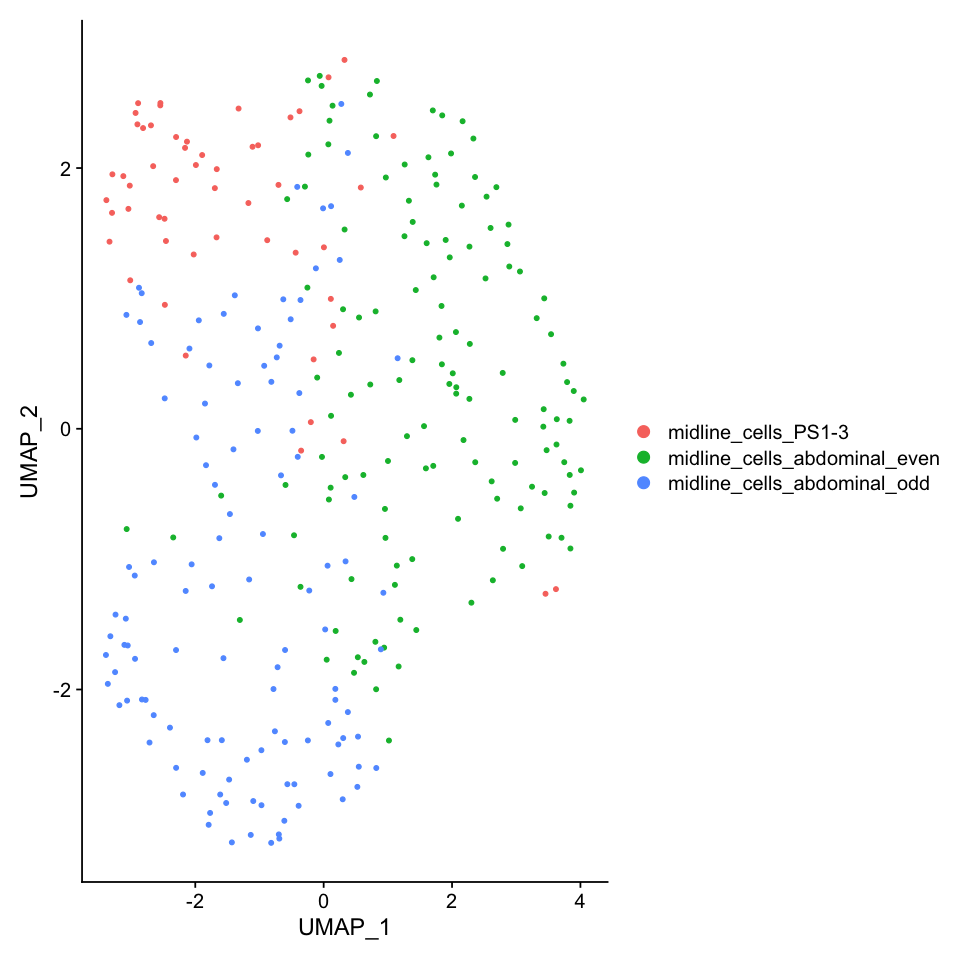

In [25]:
options(repr.plot.width=8, repr.plot.height=8)
fig <- DimPlot(seu.midline, reduction =  "umap", label = FALSE)

fig
ggsave(fig, file = "./figures/03_midline_subclustering_integrate_all/midline_umap2.eps", dpi = 300)

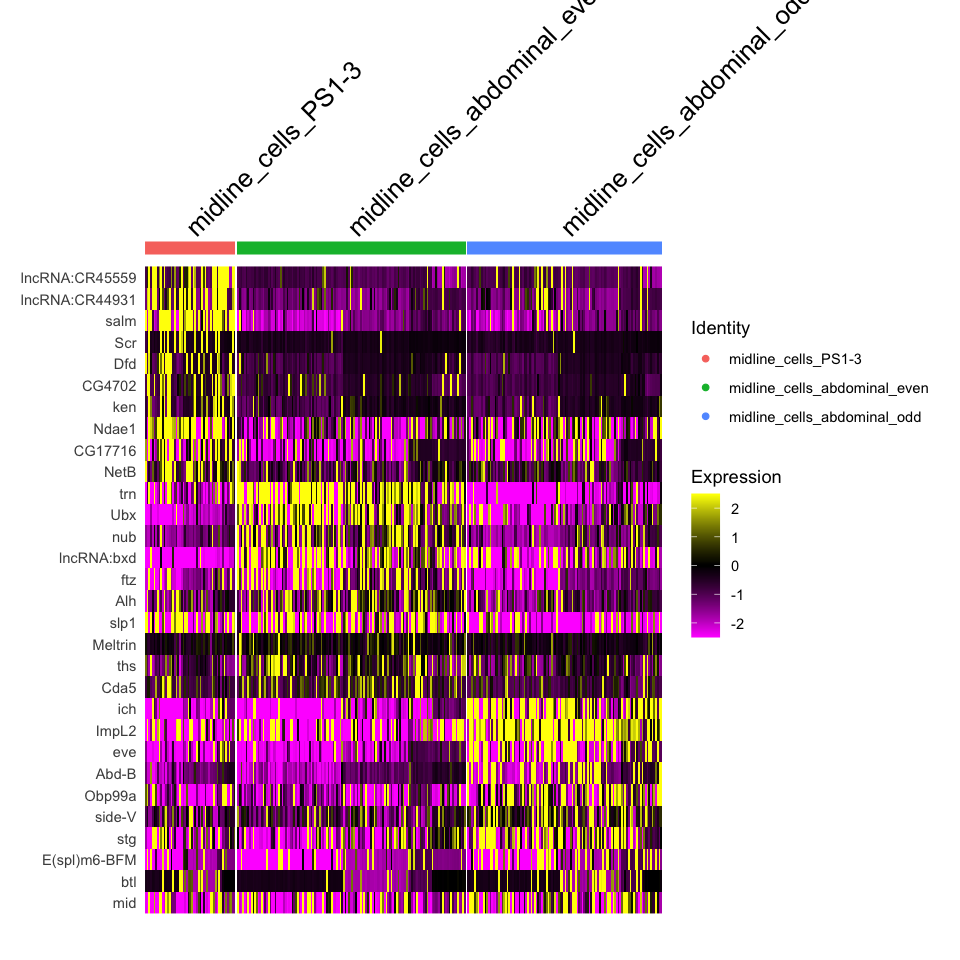

In [26]:
options(repr.plot.width=8, repr.plot.height=8)
fig <- DoHeatmap(seu.midline, features = c(all.markers.top10$gene))
fig
ggsave(fig, file = "./figures/03_midline_subclustering_integrate_all/midline_manualID_heatmap.eps", dpi = 300,  width = 12, height = 8)

In [27]:
saveRDS(object = seu.midline, file = '../../data/seurat_object/all_integration/subclustering/seu_midline_subclustering.obj')